## Random Forest Sales Forecast


### Cell 1: Importing Libraries

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import joblib
from sqlalchemy import create_engine
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import pandas as pd

### Cell 2: Database Connection and Data Fetching


In [14]:
# Load environment variables from .env file
load_dotenv()

# Set up the database connection using environment variables
db_url = f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(db_url)

# SQL Query to fetch the required data
query = """
SELECT
    s.salesid,
    s.customerid,
    s.stockcode,
    s.quantity,
    s.unitprice,
    s.totalprice,
    t.day,
    t.month,
    t.year,
    c.country
FROM
    sales s
JOIN
    time t ON s.timeid = t.timeid
JOIN
    customer c ON s.customerid = c.customerid
"""

# Load the data from the database
df = pd.read_sql(query, engine)

# Check for missing values
print("Missing values in the data:")
print(df.isnull().sum())


Missing values in the data:
salesid       0
customerid    0
stockcode     0
quantity      0
unitprice     0
totalprice    0
day           0
month         0
year          0
country       0
dtype: int64


### Cell 3: Data Preparation and Feature Engineering


In [15]:
# Create a new column for the date
df['Date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Feature Engineering
df['day_of_week'] = df['Date'].dt.dayofweek
df['month_of_year'] = df['Date'].dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['sales_lag_1'] = df['totalprice'].shift(1)

# Aggregating sales by date
sales_data = df.groupby('Date').agg({
    'totalprice': 'sum',
    'day_of_week': 'mean',
    'month_of_year': 'mean',
    'is_weekend': 'mean',
    'sales_lag_1': 'mean'
}).reset_index()

# Convert dates into numeric format for regression
sales_data['DateNumeric'] = (sales_data['Date'] - pd.Timestamp("1970-01-01")).dt.days


### Cell 4: Splitting Data for Training and Testing



In [16]:
# Prepare data for Random Forest Regressor
X = sales_data[['DateNumeric', 'day_of_week', 'month_of_year', 'is_weekend', 'sales_lag_1']]
y = sales_data['totalprice']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Cell 5: Hyperparameter Tuning and Model Training

In [18]:
# Define the model
model = RandomForestRegressor(random_state=42)

# Define the hyperparameters and their values to tune
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


### Cell 6: Model Evaluation

In [19]:
# Use the best model from grid search to predict sales on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the performance metrics
print(f'\n\n=====(Performance Metrics)=====') 
print(f'Mean Squared Error: {mse:.4f}') 
print(f'Mean Absolute Error: {mae:.4f}') 
print(f'R-squared (R²) Score: {r2:.4f}') 
print(f'===============================')




=====(Performance Metrics)=====
Mean Squared Error: 7827491.7860
Mean Absolute Error: 2148.2670
R-squared (R²) Score: 0.8122


### Cell 7: Visualizing Actual vs Predicted Sales

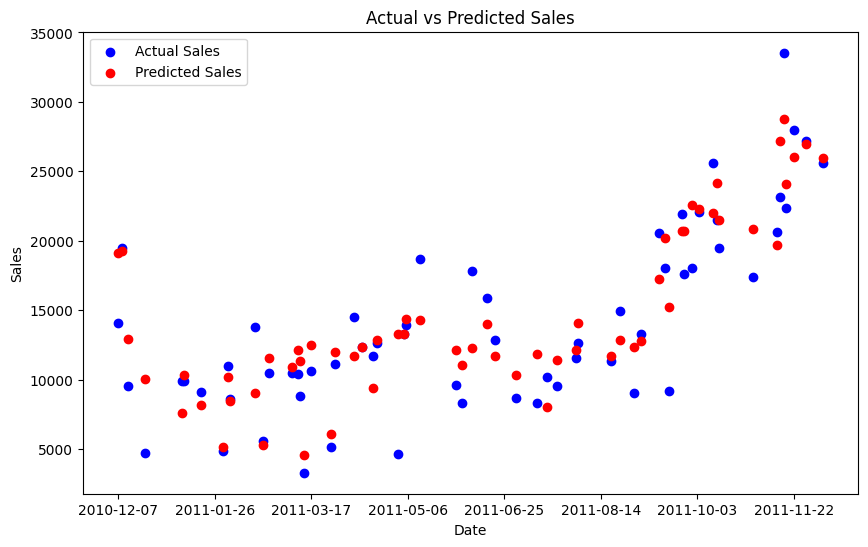

In [20]:
# Plot the actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.scatter(X_test['DateNumeric'], y_test, color='blue', label='Actual Sales')
plt.scatter(X_test['DateNumeric'], y_pred, color='red', label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()


### Cell 8: Forecasting Future Sales (Next 7 Days)

In [21]:
# Forecast future sales (next 7 days)
future_dates = pd.date_range(start=sales_data['Date'].max() + pd.Timedelta(days=1), periods=7)

# # Forecast future sales (next 30 days)
# future_dates = pd.date_range(start=sales_data['Date'].max() + pd.Timedelta(days=1), periods=30)

# Create a DataFrame for future dates
future_df = pd.DataFrame({'Date': future_dates})

# Add additional features
future_df['DateNumeric'] = (future_df['Date'] - pd.Timestamp("1970-01-01")).dt.days
future_df['day_of_week'] = future_df['Date'].dt.dayofweek
future_df['month_of_year'] = future_df['Date'].dt.month
future_df['is_weekend'] = future_df['day_of_week'].isin([5, 6]).astype(int)

# For 'sales_lag_1', use the last known totalprice value from training data
future_df['sales_lag_1'] = sales_data['totalprice'].iloc[-1]

# Predict future sales
future_sales = best_model.predict(future_df[['DateNumeric', 'day_of_week', 'month_of_year', 'is_weekend', 'sales_lag_1']])

# Save the Random Forest model
joblib.dump(best_model, 'sales_forecasting_rf_model2.pkl')


['sales_forecasting_rf_model2.pkl']

### Cell 9: Visualizing Future Sales Forecast

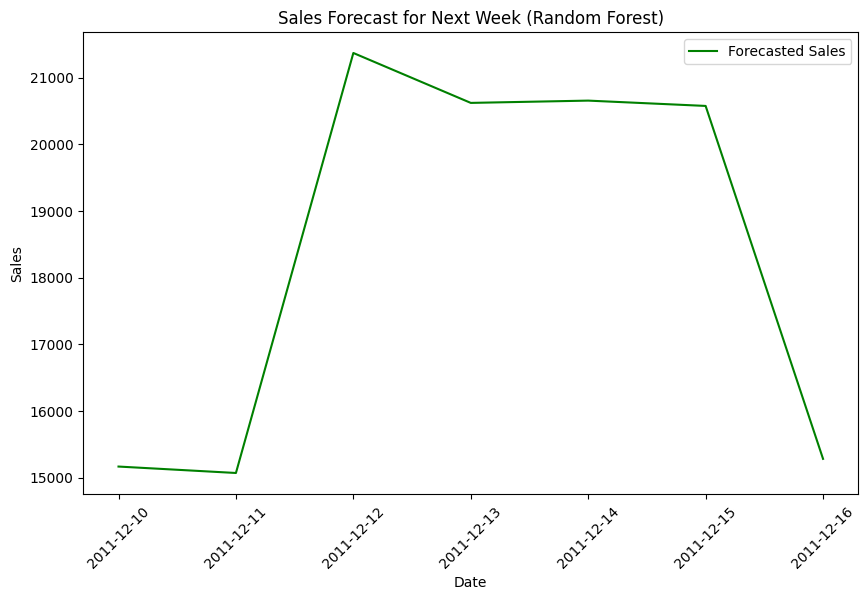

In [22]:
# Plot future sales
plt.figure(figsize=(10, 6))
plt.plot(future_dates, future_sales, label='Forecasted Sales', color='green')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast for Next Week (Random Forest)')
plt.xticks(rotation=45)
plt.legend()
plt.show()
